In [1]:
import numpy                 as     np
import numpy.linalg          as     npl                 
import scipy                 as     sp
from   scipy                 import ndimage    as ndi
import pandas as pd
import seaborn as sns
import re

from   skimage               import data
from   skimage.util          import img_as_float
from   skimage.filters       import gabor_kernel
from   sklearn.preprocessing import scale

from   numbers               import Number   

import os, sys, math, itertools, collections

%matplotlib notebook
#%gui qt
import matplotlib
import matplotlib.pyplot     as     plt

import neuropythy            as     neuro
import neuropythy.freesurfer as     nfs

for p in ['/home/billbrod/Documents/SCO-test-data/Freesurfer_subjects', '/Volumes/server/Freesurfer_subjects/']:
    if p not in nfs.subject_paths():
        nfs.add_subject_path(p)

import sco

import model_comparison_script

def reload_sco():
    reload(sys.modules['sco.core'])
    reload(sys.modules['sco.anatomy.core'])
    reload(sys.modules['sco.stimulus.core'])
    reload(sys.modules['sco.pRF.core'])
    reload(sys.modules['sco.normalization.core'])
    reload(sys.modules['sco.anatomy'])
    reload(sys.modules['sco.stimulus'])
    reload(sys.modules['sco.pRF'])
    reload(sys.modules['sco.normalization'])
    reload(sys.modules['sco'])
    reload(sys.modules['sco.model_comparison'])
    import sco

In [39]:
# this should only be used for testing, otherwise, use makefile as below
# stimuli_idx = [69, 70, 71, 72]
# model_df, results = model_comparison_script.main("stimuli.mat", stimuli_idx, range(3,6), 'test-sub', model_df_path='./test.csv')

Now, use the Makefile to create the full dataframe

In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [38]:
%%bash
export PATH=$PATH:/Applications/MATLAB_R2014a8.3.app/bin/
make fullclean
make MATLAB_soc_model_params.csv

Process is terminated.


In [49]:
stimuli_idx = np.asarray(range(156))+69
stimulus_model_names = sp.io.loadmat('./soc_model_params_image_names.mat')['image_names']

In [41]:
model_df = pd.read_csv("MATLAB_soc_model_params.csv")                    

In [52]:
stimuli_names = sp.io.loadmat("sco/model_comparison/stimuliNames.mat")['stimuliNames']
stimuli_names = stimuli_names[0, stimuli_idx]
stimuli_names = np.asarray([i[0] for i in stimuli_names])

In [43]:
stimuli = sp.io.loadmat("stimuli.mat")['images']
stimuli = stimuli[0, :]

In [44]:
def create_plot_df(condition):
    tmp = []
    if True in condition:
        stimulus_iterate = stimuli_idx[np.where(condition)]
    else:
        # assume it's just the index nubmers directly
        stimulus_iterate = condition
    for n in stimulus_iterate:
        tmp.append(np.where(["%04d"%n in name for name in stimulus_model_names]))
    names = stimulus_model_names[np.asarray(tmp).flatten()]
    plot_df = model_df[["MATLAB_predicted_responses_image_%s"%i for i in names]+["predicted_responses_image_%s"%i for i in names]]

    plot_df = plot_df.reset_index().rename(columns={'index':'voxel'})
    plot_df=pd.wide_to_long(plot_df, stubnames=["predicted_responses", "MATLAB_predicted_responses"],i='voxel',j='image')
    plot_df = plot_df.rename(columns={'predicted_responses':'predicted_responses_languagepython', 'MATLAB_predicted_responses': 'predicted_responses_languageMATLAB'})
    plot_df=plot_df.reset_index()
    plot_df = pd.wide_to_long(plot_df,['predicted_responses'],i='voxel',j='language')
    plot_df = plot_df.reset_index()

    plot_df['language'] = plot_df['language'].apply(lambda x: x.replace('_language',''))
    plot_df['image']=plot_df['image'].apply(lambda x: x.replace('_image_',''))
    
    plot_df['subimage'] = plot_df['image'].apply(lambda x: re.search(r'[0-9]*_sub([0-9]*)',x).groups()[0])
    plot_df['image'] = plot_df['image'].apply(lambda x: re.search(r'([0-9]*)_sub[0-9]*',x).groups()[0])
    return plot_df

In [45]:
def plot_stimuli(condition, subflag=False):
    if True in condition:
        tmp_idx = stimuli_idx[np.where(condition)]
    else:
#         assume it's just the index numbers directly
        tmp_idx = np.asarray(condition)+1
    plt.figure(figsize=[10,10])
    if not subflag:
        for i, idx in enumerate(tmp_idx):
            ax = plt.subplot(np.ceil(np.sqrt(len(tmp_idx))),np.ceil(np.sqrt(len(tmp_idx))),i+1)
            plt.imshow(stimuli[idx][:,:,0],cmap='gray',vmin=0,vmax=255)
            plt.title((idx, 0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
    else:
        for idx in range(stimuli[tmp_idx[subflag]].shape[2]):
            ax = plt.subplot(np.ceil(np.sqrt(stimuli[tmp_idx[subflag]].shape[2])),np.ceil(np.sqrt(stimuli[tmp_idx[subflag]].shape[2])),idx+1)
            plt.imshow(stimuli[tmp_idx[subflag]][:,:,idx],cmap='gray',vmin=0,vmax=255)
            plt.title((tmp_idx[subflag], idx))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

In [53]:
condition_title = 'orientations'
condition = ['grating_ori' == name for name in stimuli_names]

In [55]:
condition_title = 'grating'
condition = ['grating_contrast' == name for name in stimuli_names]

In [57]:
condition_title = 'plaid'
condition = ['plaid_contrast' == name for name in stimuli_names]

In [59]:
condition_title = 'circular'
condition = ['circular_contrast' == name for name in stimuli_names]

In [61]:
condition_title = 'sparse'
condition = ['pattern_sparse' == name for name in stimuli_names]

In [14]:
condition_title = 'test'
condition = [69, 70, 71, 72]

<IPython.core.display.Javascript object>


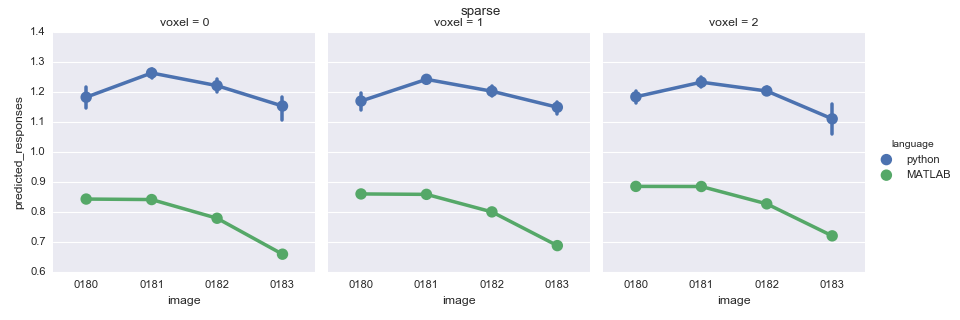

In [62]:
plot_df = create_plot_df(condition)
#plot_df=plot_df[(plot_df.language=='MATLAB')&(plot_df.voxel==0)]

g=sns.factorplot(data=plot_df,y='predicted_responses',x='image',hue='language', col='voxel', col_wrap=3, 
                 legend_out=True)#, kind='strip',jitter=True)
g.fig.suptitle(condition_title)
g.fig.subplots_adjust(top=.9, right=.9)

<IPython.core.display.Javascript object>


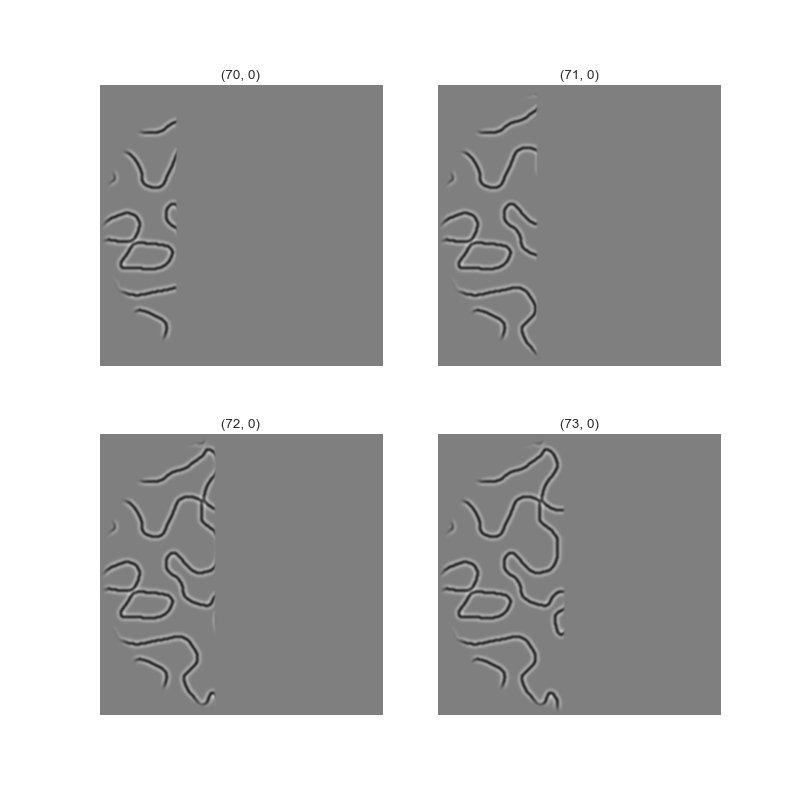

In [23]:
plot_stimuli(condition)